Dependencies

In [7]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

Preprocessing

In [8]:
import pathlib

dirname = os.path.dirname(pathlib.Path().resolve())
filename = "data/housing_price_dataset.csv"
data = pd.read_csv(os.path.join(dirname, filename))

data.head()


,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,Rural,1969,215355.283618
1,2459,3,2,Rural,1980,195014.221626
2,1860,2,1,Suburb,1970,306891.012076
3,2294,2,1,Urban,1996,206786.787153
4,2130,5,2,Suburb,2001,272436.239065


In [9]:
def map_values(value):
    if (value == 'Rural'):
        return 0
    elif (value == 'Suburb'):
        return 1
    elif (value == 'Urban'):
        return 2
    return 3


In [10]:
data['Neighborhood'] = data['Neighborhood'].astype('str').map(map_values)
data['Age'] = 2023 - data['YearBuilt']
data = data.drop('YearBuilt', axis=1)
# data['SquareMeter'] = data['SquareFeet'] * 0.092903
# creates float numbers, and minimal rounding error


In [11]:
from sklearn.model_selection import train_test_split

## Test data
train, test = train_test_split(data, test_size=0.15, random_state=42)

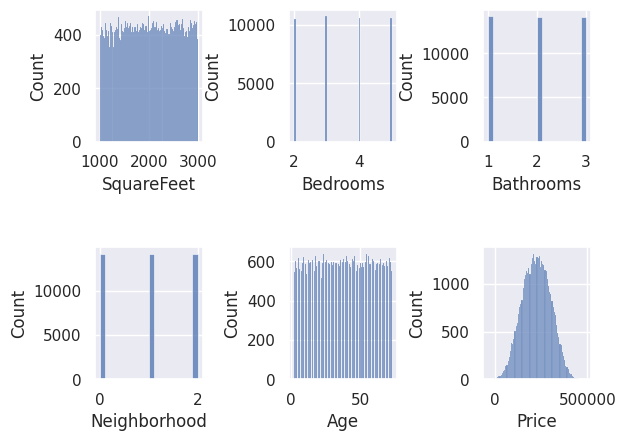

In [12]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.8, wspace=0.8)
ax = fig.add_subplot(2, 3, 1)
sns.histplot(train["SquareFeet"], bins = 100, ax=ax)
ax = fig.add_subplot(2, 3, 2)
sns.histplot(train["Bedrooms"], ax=ax)
ax = fig.add_subplot(2, 3, 3)
sns.histplot(train["Bathrooms"],ax=ax)
ax = fig.add_subplot(2, 3, 4)
sns.histplot(train["Neighborhood"],ax=ax)
ax = fig.add_subplot(2, 3, 5)
sns.histplot(train["Age"], bins = 100,ax=ax)
ax = fig.add_subplot(2, 3, 6)
sns.histplot(train["Price"], ax=ax)
plt.show()

<Axes: >

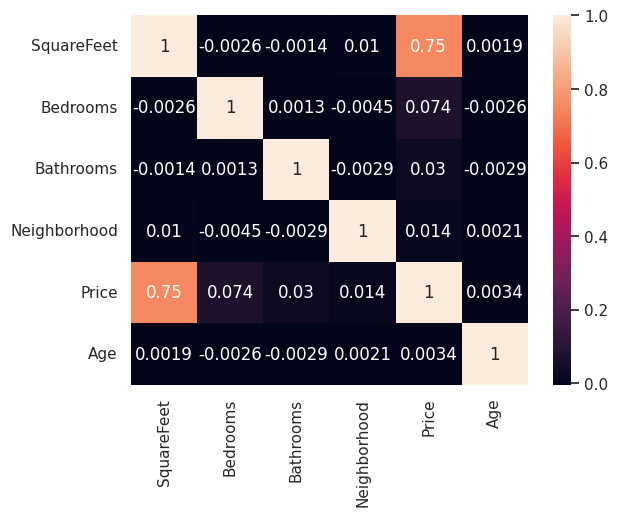

In [13]:
sns.heatmap(train.corr(), annot=True)

In [14]:
# delete faulty data
train.drop(train[train.Price <= 0].index, axis=0, inplace=True)
train.drop_duplicates(keep=False, inplace=True)
train.shape

(42481, 6)

In [15]:
print(train.isna().any(axis=0))
print(train.isnull().any(axis=0))

SquareFeet      False
Bedrooms        False
Bathrooms       False
Neighborhood    False
Price           False
Age             False
dtype: bool
SquareFeet      False
Bedrooms        False
Bathrooms       False
Neighborhood    False
Price           False
Age             False
dtype: bool


In [16]:
import sklearn
from sklearn.preprocessing import MinMaxScaler

sklearn.set_config(transform_output="pandas")
scaler = MinMaxScaler(feature_range=(0,1))
train = scaler.fit_transform(train)
test = scaler.fit_transform(test)

In [17]:
## Validation data
labels = train['Price']
train = train.drop(columns = 'Price', axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(train, labels, test_size=0.15, random_state=42)

Model

In [18]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert to 2D PyTorch tensors
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    #print("using ", device)
    return device

device = get_device()

# convert a df to tensor to be used in pytorch
def dataframe_to_tensor(df):
    return torch.from_numpy(df.values).float().to(device)

X_train = dataframe_to_tensor(X_train)
y_train = dataframe_to_tensor(y_train)
X_valid = dataframe_to_tensor(X_valid)
y_valid = dataframe_to_tensor(y_valid)


y_test = test["Price"]
X_test = test.drop(columns="Price")
X_test = dataframe_to_tensor(X_test)
y_test = dataframe_to_tensor(y_test)

# y_train.reshape((y_train.shape[0], 1))
# y_valid.reshape((y_valid.shape[0], 1))
# y_test.reshape((y_test.shape[0], 1))


train_ds = TensorDataset(X_train, y_train)
valid_ds = TensorDataset(X_valid, y_valid)
test_ds = TensorDataset(X_test, y_test)

In [19]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(train_ds, batch_size=batch_size)
valid_dataloader = DataLoader(valid_ds, batch_size=batch_size)
test_dataloader = DataLoader(test_ds, batch_size=batch_size)

for XX, yy in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {XX.shape}")
    print(f"Shape of y: {yy.shape} {yy.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 5])
Shape of y: torch.Size([64]) torch.float32


In [20]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(5, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=5, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [21]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [22]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (XX, yy) in enumerate(dataloader):
        yy = yy.to(device).reshape((yy.shape[0], 1))

        # Compute prediction error
        pred = model(XX)
        loss = loss_fn(pred, yy)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(XX)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [23]:
from sklearn.metrics import mean_squared_error, r2_score

def acc_func(loc_pred, loc_y):
    # RMSE root mean square error
    #return (mean_squared_error(loc_y, loc_pred, squared=False))
    
    # R2 error
    return (r2_score(loc_y, loc_pred))

In [24]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for XX, yy in dataloader:
            XX, yy = XX.to(device), yy.to(device)
            yy = yy.reshape((yy.shape[0], 1))
            
            pred = model(XX)
            test_loss += loss_fn(pred, yy).item()
            
            #correct if the difference is < 10%
            correct += acc_func(pred, yy)
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
%%capture cap

epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

In [ ]:
with open('../results/housing_train_initial_nn_all.txt', 'w+') as f:
    f.write(cap.stdout)

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(model )

## Test Model

In [19]:
%%capture cap
test(valid_dataloader, model, loss_fn)

In [ ]:
with open('../results/housing_test_initial_nn_all.txt', 'w+') as f:
    f.write(cap.stdout)

# Parametric NN

## Shrink Dataset

In [25]:
_, X_train_small, _, y_train_small = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [26]:
print(len(X_train_small))
print(len(y_train_small))
X_train_small
y_train_small

7222
7222


tensor([0.6188, 0.3351, 0.2810,  ..., 0.3894, 0.4789, 0.3474])

In [27]:
X_ttrain_small, X_test_small, y_ttrain_small, y_test_small = train_test_split(X_train_small, y_train_small, test_size=0.3, random_state=42)

In [28]:
train_small_ds = TensorDataset(X_ttrain_small, y_ttrain_small)
test_small_ds = TensorDataset(X_test_small, y_test_small)

In [29]:
%load_ext autoreload
%autoreload 2

## Grid Search

In [30]:
import NNModel

In [31]:
layer = [len(X_train[0]), 50, 50, 1]
nnmodel = NNModel.NNModel(layer, device, acc_func=acc_func, loss_func=nn.MSELoss, reshape=True)

In [36]:
%%capture cap
dict_param_1 = {"learning_rate": [0.01, 0.05, 0.1], "batch_size": [32, 64, 128]}
best, acc = nnmodel.grid_search(dict_param_1, train_small_ds, test_small_ds, epochs=30, cv=True, k_folds=3)
print(best)

--------------------------------
FOLD 0
--------------------------------
False
The actual fold accuracy is  0.5070208175611004 

FOLD 1
--------------------------------
False
The actual fold accuracy is  0.5551750247972382 

FOLD 2
--------------------------------
False
The actual fold accuracy is  0.5444118429489189 

Parameter Combination (0.01, 32) with keys ['learning_rate', 'batch_size']
 Accuracy: 0.5

--------------------------------
FOLD 0
--------------------------------
False
The actual fold accuracy is  0.5245475190692771 

FOLD 1
--------------------------------
False
The actual fold accuracy is  0.5266670598342075 

FOLD 2
--------------------------------
False
Early stopping at epoch: 6
The actual fold accuracy is  -8.882417255089031 

Parameter Combination (0.01, 64) with keys ['learning_rate', 'batch_size']
 Accuracy: -2.6

--------------------------------
FOLD 0
--------------------------------
False
The actual fold accuracy is  0.3524743994139392 

FOLD 1
------------

Traceback (most recent call last):
  File "/home/czeh/miniconda3/envs/ml/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1859679/3160427037.py", line 3, in <module>
    best, acc = nnmodel.grid_search(dict_param_1, train_small_ds, test_small_ds, epochs=30, cv=True, k_folds=3)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/czeh/ml/ML-NN-Parameter-Search/src/NNModel.py", line 246, in grid_search
    if(acc > best_acc):
          ^^^^^^^^^^^^^^
  File "/home/czeh/ml/ML-NN-Parameter-Search/src/NNModel.py", line 208, in run_cv
    acc, test_loss = self.test(valid_dataloader, self.loss_fn, out=out)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/czeh/ml/ML-NN-Parameter-Search/src/NNModel.py", line 82, in train
    for batch, (XX, yy) in enumerate(dataloader):
  

In [ ]:
with open('../results/housing_grid_search_training_1p.txt', 'w+') as f:
    f.write(cap.stdout)

In [ ]:
%%capture cap
nnmodel.defaults["learning_rate"] = best[0]
nnmodel.defaults["batch_size"] = best[1]

test_layer = [[len(X_train[0]), 50, 50, 1], [len(X_train[0]), 50, 100, 50, 1], [len(X_train[0]), 100, 100, 1]]
dict_param_2 = {"activation": [nn.ReLU, nn.Sigmoid, nn.Identity], "dropout": [0, 0.2, 0.3, 0.5], "layer": test_layer}
best, acc = nnmodel.grid_search(dict_param_2, train_small_ds, test_small_ds, epochs=30)
print(best)

In [ ]:
with open('../results/housing_grid_search_model_1p.txt', 'w+') as f:
    f.write(cap.stdout)

In [ ]:
nnmodel.defaults["activation"] = best[0]
nnmodel.defaults["dropout"] = best[1]
nnmodel.defaults["layer"] = best[2]

In [ ]:
%%capture cap
print(nnmodel.defaults)
nnmodel.create_model(nnmodel.defaults["layer"], nnmodel.defaults["activation"], nnmodel.defaults["dropout"])
acc = nnmodel.run(nnmodel.defaults, train_ds, test_ds, 100)
print(acc)

In [ ]:
with open('../results/housing_grid_search_res.txt', 'w+') as f:
    f.write(cap.stdout)

In [ ]:
%%capture cap
test(valid_dataloader, nnmodel.model, nnmodel.loss_fn)

In [ ]:
with open('../results/housing_grid_search_res_valid.txt', 'w+') as f:
    f.write(cap.stdout)

In [97]:
%%capture cap
nnmodel.defaults['learning_rate'] = 0.1
nnmodel.defaults['layer'] = [5, 100, 100, 1]
nnmodel.defaults['batch_size'] = 64
nnmodel.defaults['dropout'] = 0
nnmodel.defaults['activation'] = nn.ReLU
nnmodel.acc_func = acc_func
cv_acc = nnmodel.run_cv(nnmodel.defaults, train_small_ds, test_small_ds, epochs=100, k_folds=5)
print(cv_acc)

In [98]:
with open('../results/housing_grid_search_res_cv.txt', 'w+') as f:
    f.write(cap.stdout)

## Local Search

In [37]:
nnmodel = NNModel.NNModel(layer, device, acc_func=acc_func, loss_func=nn.MSELoss, reshape=True)

In [ ]:
%%capture cap
init_param = {"learning_rate": 0.01, "batch_size": 64}
best, acc = nnmodel.local_search(init_param, train_small_ds, test_small_ds, steps=50, epochs=30)
print(best)

In [ ]:
with open('../results/housing_local_search_training_1p.txt', 'w+') as f:
    f.write(cap.stdout)

In [ ]:
%%capture cap
nnmodel.defaults["learning_rate"] = best[0]
nnmodel.defaults["batch_size"] = best[1]
init_param = {"layer": layer, "dropout": 0.2, "activation": nn.ReLU}
best, acc = nnmodel.local_search(init_param, train_small_ds, test_small_ds, steps=50, epochs=10)
print(best)

In [ ]:
with open('../results/housing_local_search_model_1p.txt', 'w+') as f:
    f.write(cap.stdout)

In [ ]:
nnmodel.defaults["activation"] = best[0]
nnmodel.defaults["dropout"] = best[1]
nnmodel.defaults["layer"] = best[2]

In [ ]:
%%capture cap
print(nnmodel.defaults)
nnmodel.create_model(nnmodel.defaults["layer"], nnmodel.defaults["activation"], nnmodel.defaults["dropout"])
acc = nnmodel.run(nnmodel.defaults, train_ds, test_ds, 100)
print(acc)

In [ ]:
with open('../results/housing_local_search_res.txt', 'w+') as f:
    f.write(cap.stdout)

In [ ]:
%%capture cap
test(valid_dataloader, nnmodel.model, nnmodel.loss_fn)

In [ ]:
with open('../results/housing_local_search_res_valid.txt', 'w+') as f:
    f.write(cap.stdout)

## Cross validation

In [40]:
nnmodel = NNModel.NNModel(layer, device, acc_func=acc_func, loss_func=nn.MSELoss, reshape=True)

In [41]:
nnmodel.run_cv(nnmodel.defaults, train_small_ds, test_small_ds, epochs=10, out=False)

--------------------------------
FOLD 0
--------------------------------
The actual fold accuracy is  0.35263044096811 

FOLD 1
--------------------------------
The actual fold accuracy is  0.3396580664223468 

FOLD 2
--------------------------------
Early stopping at epoch: 5
The actual fold accuracy is  -8.801103924653999 



-2.702938472421181

# Random Forest

In [78]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

rf = RandomForestRegressor(n_estimators=3, random_state=42)  

rf.fit(X_train, y_train)
y_prediction = rf.predict(X_valid)

In [79]:
%%capture cap

from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_valid, y_prediction)
print(f'Mean Squared Error: {mse}')

r2 = r2_score(y_valid, y_prediction)
print(f'R-squared: {r2}')

rmse = mean_squared_error(y_valid, y_prediction, squared=False)
print(f'Root Mean Squared Error: {mse}')

cv_rmse = np.mean(cross_val_score(rf, X_valid, y_valid, scoring="neg_root_mean_squared_error")) * (-1)
print(f'Cross validation RMSE: {cv_rmse}')

cv_r_square = np.mean(cross_val_score(rf, X_valid, y_valid))
print(f'Cross validation R-squared: {cv_r_square}')

In [80]:
with open('../results/housing_forest_all.txt', 'w+') as f:
    f.write(cap.stdout)